# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. The goal is to predict payment defaults by developing a neural network. 

In [1]:
#amount some libraries for the analysis of the data and development of the model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

#preprocessing ops
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# DL ops
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
#just import some random layers to showcase -- won't use them all
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Inspecting the data

While exploring the dataset, lacking the variable to be predicted, we immediately notice that the size is 24000 rows and 24
columns (one of which is the ID, i.e. the variable that identifies the observation). Of the remaining 23, "SEX", "EDUCATION" AND "MARRIAGE" are categorical variables and assume integer values. An initial analysis shows that there are some values of "MARRIAGE" and "EDUCATION" that are not documented in the available information of the dataset. In addition, there don't appear to be any null values present. 

In [3]:
X_data = pd.read_csv('drive/MyDrive/X_train.csv')
X_data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,21754,80000.0,2,2,2,24,0,0,0,0,0,0,75125.0,77353.0,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
1,252,30000.0,1,2,2,28,0,0,0,0,0,0,29242.0,29507.0,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
2,22942,180000.0,2,5,1,44,0,0,-1,-1,-1,-1,20916.0,0.0,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0
3,619,60000.0,1,1,2,25,0,0,0,0,0,0,58839.0,53235.0,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0
4,17091,130000.0,2,2,2,25,0,0,0,0,0,0,111587.0,112348.0,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,29803,50000.0,1,2,2,32,0,0,0,0,0,0,52475.0,53600.0,55739.0,55957.0,29238.0,6119.0,2000.0,3000.0,1591.0,72.0,1134.0,73421.0
23996,5391,200000.0,1,1,2,37,2,2,2,2,2,2,157131.0,166590.0,168386.0,164182.0,169029.0,172084.0,13500.0,6000.0,0.0,7500.0,6000.0,4000.0
23997,861,50000.0,1,1,2,26,-2,-2,-2,-2,-2,-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,15796,70000.0,2,2,2,25,0,0,0,0,2,2,73939.0,70488.0,51152.0,35122.0,28633.0,28039.0,3000.0,2000.0,4500.0,1200.0,0.0,1200.0


In [4]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         24000 non-null  int64  
 1   LIMIT_BAL  24000 non-null  float64
 2   SEX        24000 non-null  int64  
 3   EDUCATION  24000 non-null  int64  
 4   MARRIAGE   24000 non-null  int64  
 5   AGE        24000 non-null  int64  
 6   PAY_0      24000 non-null  int64  
 7   PAY_2      24000 non-null  int64  
 8   PAY_3      24000 non-null  int64  
 9   PAY_4      24000 non-null  int64  
 10  PAY_5      24000 non-null  int64  
 11  PAY_6      24000 non-null  int64  
 12  BILL_AMT1  24000 non-null  float64
 13  BILL_AMT2  24000 non-null  float64
 14  BILL_AMT3  24000 non-null  float64
 15  BILL_AMT4  24000 non-null  float64
 16  BILL_AMT5  24000 non-null  float64
 17  BILL_AMT6  24000 non-null  float64
 18  PAY_AMT1   24000 non-null  float64
 19  PAY_AMT2   24000 non-null  float64
 20  PAY_AM

In [5]:
X_data[['SEX', 'EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,24000.000000,24000.000000,24000.000000
mean,1.604917,1.854000,1.551417
std,0.488879,0.792176,0.522766
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


In [6]:
X_data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,-0.016667,-0.131375,-0.168167,-0.220417,-0.265167,-0.288750
std,1.126473,1.197675,1.191685,1.168107,1.132949,1.152394
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [7]:
X_data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000
mean,50927.468417,48914.770500,4.675708e+04,43013.532167,40150.333000,38763.540458
std,73400.840274,70923.493353,6.926506e+04,64069.494705,60635.882129,59281.986863
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000
25%,3537.000000,2989.750000,2.699500e+03,2329.000000,1763.000000,1271.750000
50%,22321.500000,21140.500000,2.005000e+04,19010.000000,18085.000000,17108.500000
75%,66377.000000,63035.250000,5.952925e+04,53927.750000,50007.500000,49101.750000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [8]:
X_data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,5670.826542,5.961101e+03,5258.246500,4880.847125,4818.849250,5159.462125
std,17084.401034,2.428412e+04,18242.618988,16304.718844,15619.425964,17458.604219
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.615000e+02,390.000000,285.750000,240.750000,112.750000
50%,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,527143.000000


## Preparing the data

For the Education and Marriage variables, undocumented values were imputed to the 'Other' category. After that, the dataset containing only the variable to be predicted was imported and the distribution was calculated. The two classes result unbalanced with a percentage equal to 78-22% in favor of the "Default payment = 0 (no)". This will be considered later. Finally, before starting to build the model, it is necessary to standardize the data (except for the target variable)


In [9]:
oth = (X_data.EDUCATION == 5) | (X_data.EDUCATION == 6) | (X_data.EDUCATION == 0)
X_data.loc[oth, 'EDUCATION'] = 4
X_data.EDUCATION.value_counts()

2    11186
1     8481
3     3959
4      374
Name: EDUCATION, dtype: int64

In [10]:
X_data.loc[X_data.MARRIAGE == 0, 'MARRIAGE'] = 3
X_data.MARRIAGE.value_counts()

2    12747
1    10942
3      311
Name: MARRIAGE, dtype: int64

In [11]:
Y_data = pd.read_csv('drive/MyDrive/y_train.csv')
Y_data

,ID,default.payment.next.month
0,21754,0
1,252,0
2,22942,0
3,619,0
4,17091,0
...,...,...
23995,29803,0
23996,5391,1
23997,861,0
23998,15796,1


In [12]:
Y_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          24000 non-null  int64
 1   default.payment.next.month  24000 non-null  int64
dtypes: int64(2)
memory usage: 375.1 KB


In [13]:
Y_data["default.payment.next.month"].value_counts()

0    18677
1     5323
Name: default.payment.next.month, dtype: int64

In [14]:
neg, pos = np.bincount(Y_data["default.payment.next.month"])
total = neg + pos
print(pos/total*100) 

22.179166666666667


In [15]:
Data = Y_data.merge(X_data, left_on='ID', right_on='ID')
Data.drop('ID', axis=1, inplace=True)

In [16]:
#Preprocessing of the test set
X_test = pd.read_csv('drive/MyDrive/X_test.csv')
X_test

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2309,30000.0,1,2,2,25,0,0,0,0,0,0,8864.0,10062.0,11581.0,12580.0,13716.0,14828.0,1500.0,2000.0,1500.0,1500.0,1500.0,2000.0
1,22405,150000.0,2,1,2,26,0,0,0,0,0,0,136736.0,125651.0,116684.0,101581.0,77741.0,77264.0,4486.0,4235.0,3161.0,2647.0,2669.0,2669.0
2,23398,70000.0,2,3,1,32,0,0,0,0,0,0,70122.0,69080.0,68530.0,69753.0,70111.0,70212.0,2431.0,3112.0,3000.0,2438.0,2500.0,2554.0
3,25059,130000.0,1,3,2,49,0,0,0,0,0,-1,20678.0,18956.0,16172.0,16898.0,11236.0,6944.0,1610.0,1808.0,7014.0,27.0,7011.0,4408.0
4,2665,50000.0,2,2,2,36,0,0,0,0,0,2,94228.0,47635.0,42361.0,19574.0,20295.0,19439.0,2000.0,1500.0,1000.0,1800.0,0.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2211,360000.0,2,1,2,27,1,-2,-1,-1,-1,-1,0.0,0.0,830.0,0.0,1271.0,179.0,0.0,830.0,0.0,1271.0,179.0,1970.0
5996,14145,500000.0,2,1,2,28,2,0,0,2,0,0,98541.0,102052.0,111690.0,78070.0,78376.0,80912.0,6000.0,13151.0,0.0,3000.0,5000.0,10000.0
5997,23109,60000.0,2,1,1,28,0,0,0,0,0,2,46233.0,47263.0,48696.0,50385.0,52045.0,52661.0,2100.0,2500.0,2500.0,2500.0,1600.0,1500.0
5998,25704,20000.0,2,1,2,29,1,-1,-1,-1,-1,-1,0.0,2494.0,3967.0,1364.0,600.0,0.0,2494.0,3967.0,1370.0,600.0,0.0,0.0


In [17]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         6000 non-null   int64  
 1   LIMIT_BAL  6000 non-null   float64
 2   SEX        6000 non-null   int64  
 3   EDUCATION  6000 non-null   int64  
 4   MARRIAGE   6000 non-null   int64  
 5   AGE        6000 non-null   int64  
 6   PAY_0      6000 non-null   int64  
 7   PAY_2      6000 non-null   int64  
 8   PAY_3      6000 non-null   int64  
 9   PAY_4      6000 non-null   int64  
 10  PAY_5      6000 non-null   int64  
 11  PAY_6      6000 non-null   int64  
 12  BILL_AMT1  6000 non-null   float64
 13  BILL_AMT2  6000 non-null   float64
 14  BILL_AMT3  6000 non-null   float64
 15  BILL_AMT4  6000 non-null   float64
 16  BILL_AMT5  6000 non-null   float64
 17  BILL_AMT6  6000 non-null   float64
 18  PAY_AMT1   6000 non-null   float64
 19  PAY_AMT2   6000 non-null   float64
 20  PAY_AMT3

In [18]:
oth = (X_test.EDUCATION == 5) | (X_test.EDUCATION == 6) | (X_test.EDUCATION == 0)
X_test.loc[oth, 'EDUCATION'] = 4
X_test.EDUCATION.value_counts()

2    2844
1    2104
3     958
4      94
Name: EDUCATION, dtype: int64

In [19]:
X_test.loc[X_test.MARRIAGE == 0, 'MARRIAGE'] = 3
X_test.MARRIAGE.value_counts()

2    3217
1    2717
3      66
Name: MARRIAGE, dtype: int64

In [20]:
X_test.drop('ID', axis=1, inplace=True)

In [21]:
# Train-Va split
X_train, X_val = train_test_split(Data, test_size=0.2)

In [22]:
Y_train = np.array(X_train.pop('default.payment.next.month'))
Y_val = np.array(X_val.pop('default.payment.next.month'))
 
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test= np.array(X_test)

In [23]:
scaler= StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.fit_transform(X_test)
print('Training labels', Y_train.shape)
print('Validation labels', Y_val.shape)

print('Training features', X_train.shape)
print('Validation features', X_val.shape)
print('Test features', X_test.shape)

Training labels (19200,)
Validation labels (4800,)
Training features (19200, 23)
Validation features (4800, 23)
Test features (6000, 23)


## Building the network

Definition of the neural network with two hidden layers of 50 neurons (the first) and 25 (the second). They have been
moreover added two Layer of Dropout with rate = 0.5 in order to avoid the Overfitting. 

To initialize the weights we chose the TruncatedNormal function that generates a truncated Normal distribution truncated and forces the same forward/backward variance between layers. It is equal to RandomNormal except that the values that differ from the mean by two times the standard deviation are
eliminated and redefined.
The choice of the initial set of weights is important because it can determine the convergence of the algorithm.

At each iteration a minibatch of 2048 examples is randomly sampled, large enough to contain enough samples of the rare class within it.

We use 100 epochs to drive the algorithm, barring the intervention of Early Stopping, which stops training when there is no substantial improvement in AUC (Area Under the Curve) for more than 10 epochs.

The hidden layer neurons are characterized by the activation function Rectified Linear Unit (ReLU), which is efficient in the back propagation of the errors and has the characteristic of activating few neurons at different times making the network sparse and easy to compute.

The output layer contains only one neuron, characterized by the sigmoid activation function, which ensures a strong gradient as well as being very common in classification problems. 

An algorithm with adaptive learning rate, Adam (Adaptive Moments), was used as the optimizer, which is a variation of RMSProp + Momentum:
Momentum is incorporated directly into the first-order momentum estimation.
In RMSProp the momentum is included after rescaling the gradients.
Adam also adds a bias correction to the moments.

The loss function to be optimized is represented by Binary CrossEntropy. Other loss functions such as MAE or MAE, when combined with the output units saturate and produce low gradients. 

In [24]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.AUC(name='auc'),
]

In [25]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=8,
    mode='max',
    restore_best_weights=True)

In [26]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu',kernel_initializer='TruncatedNormal', input_shape=(23,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.binary_crossentropy,
    metrics=METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                384       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
10/10 [==============================] - 2s 41ms/step - loss: 0.6830 - accuracy: 0.5987 - auc: 0.5138 - val_loss: 0.6575 - val_accuracy: 0.7681 - val_auc: 0.4706
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.6388 - accuracy: 0.7595 - auc: 0.5246 - val_loss: 0.6171 - val_accuracy: 0.7681 - val_auc: 0.5534
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 0.5954 - accuracy: 0.7808 - auc: 0.5652 - val_loss: 0.5767 - val_accuracy: 0.7681 - val_auc: 0.6036
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.5597 - accuracy: 0.7810 - auc: 0.5978 - val_loss: 0.5472 - val_accuracy: 0.7681 - val_auc: 0.6232
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.5352 - accuracy: 0.7809 - auc: 0.6264 - val_loss: 0.5351 - val_accuracy: 0.7681 - val_auc: 0.6326
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.5252 - accuracy: 0.7811 - auc: 0.6396 - val_loss: 0.5282 -

## Analyze and comment the training results

There is no sign of overfitting as the training loss and validation curves do not diverge: both tend to decrease until they stabilize just above 0.4
However, being very close to each other, almost one above the other, we can think of an eventual underfitting.

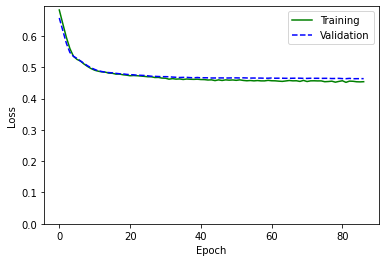

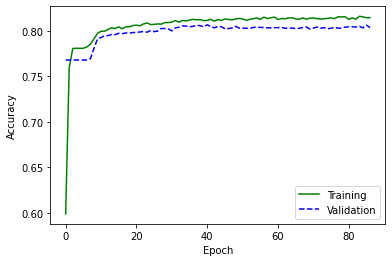

In [28]:
plt.figure()
plt.plot(history.epoch,  history.history['loss'], color="green", label='Train')
plt.plot(history.epoch, history.history['val_loss'],color="blue", linestyle="--", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, plt.ylim()[1]])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.plot(history.epoch,  history.history['accuracy'], color="green", label='Train')
plt.plot(history.epoch, history.history['val_accuracy'],color="blue", linestyle="--", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Validate the model and comment the results

Despite the accuracy is very high, it cannot be used to evaluate the classifier because of the unbalanced classes.

Focusing on the F-Measure shows that the classifier is not efficient and therefore corrections must be made for the unbalanced classes.

It can be useful to concentrate on the diminution of the False Negatives, in how much their cost could be higher regarding that one of the False Positives (in the first case "we would lose" of the fraudulent transactions, in the second one probably we would send an email to the customer asking to pay attention to the own financial situation)

In [29]:
Y_pred=model.predict(X_val)
Y_pred=Y_pred>0.5

cm=confusion_matrix(Y_val,Y_pred)
prf=precision_recall_fscore_support(Y_val,Y_pred)

print(f"confusion matrix\n {cm}")
print(f"precision\n {prf[0]}")
print(f"recall\n {prf[1]}")
print(f"f-score\n {prf[2]}")

confusion matrix
 [[3505  182]
 [ 762  351]]
precision
 [0.8214202  0.65853659]
recall
 [0.95063737 0.31536388]
f-score
 [0.88131758 0.42648846]


In [30]:
cr=classification_report(Y_val, Y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3687
           1       0.66      0.32      0.43      1113

    accuracy                           0.80      4800
   macro avg       0.74      0.63      0.65      4800
weighted avg       0.78      0.80      0.78      4800



Managing unbalanced classes

A useful remedy in the case of classification to unbalanced classes is represented from the imposition of a system of weights that gives more value to the rare class in the phase of Training (exist also other methods like Oversampling etc..)

In [31]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
w_0 = (1 / neg)*(total)/2.0 
w_1 = (1 / pos)*(total)/2.0

class_weight = {0: w_0, 1: w_1}

print('Weight for class 0: {:.2f}'.format(w_0))
print('Weight for class 1: {:.2f}'.format(w_1))

Weight for class 0: 0.64
Weight for class 1: 2.25


In [32]:
random.seed(22)
w_model = keras.Sequential([
    keras.layers.Dense(16, activation='relu',kernel_initializer='TruncatedNormal', input_shape=(23,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])
w_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.binary_crossentropy,
    metrics=METRICS)
w_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                384       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [33]:
w_history = w_model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val),
    class_weight=class_weight)

Epoch 1/100
10/10 [==============================] - 1s 38ms/step - loss: 0.6948 - accuracy: 0.5760 - auc: 0.5468 - val_loss: 0.6857 - val_accuracy: 0.6096 - val_auc: 0.6098
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.6810 - accuracy: 0.5482 - auc: 0.5829 - val_loss: 0.6790 - val_accuracy: 0.6156 - val_auc: 0.6588
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.6680 - accuracy: 0.5851 - auc: 0.6306 - val_loss: 0.6729 - val_accuracy: 0.6112 - val_auc: 0.6735
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.6572 - accuracy: 0.6198 - auc: 0.6543 - val_loss: 0.6626 - val_accuracy: 0.6256 - val_auc: 0.6821
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.6447 - accuracy: 0.6493 - auc: 0.6688 - val_loss: 0.6492 - val_accuracy: 0.6460 - val_auc: 0.6878
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.6370 - accuracy: 0.6736 - auc: 0.6777 - val_loss: 0.6372 -

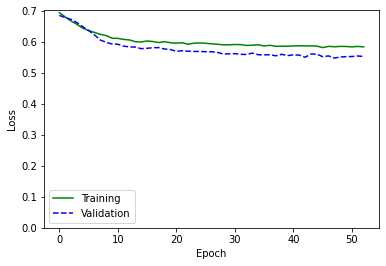

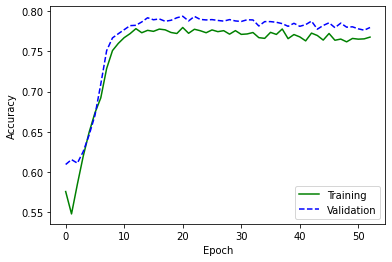

In [34]:
plt.figure()
plt.plot(w_history.epoch,  w_history.history['loss'], color="green", label='Train')
plt.plot(w_history.epoch, w_history.history['val_loss'],color="blue", linestyle="--", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, plt.ylim()[1]])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.plot(w_history.epoch,  w_history.history['accuracy'], color="green", label='Train')
plt.plot(w_history.epoch, w_history.history['val_accuracy'],color="blue", linestyle="--", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [35]:
Y_pred=w_model.predict(X_val)
Y_pred=Y_pred>0.5

cm=confusion_matrix(Y_val,Y_pred)
prf=precision_recall_fscore_support(Y_val,Y_pred)

print(f"confusion matrix\n {cm}")
print(f"precision\n {prf[0]}")
print(f"recall\n {prf[1]}")
print(f"f-score\n {prf[2]}")

confusion matrix
 [[3155  532]
 [ 514  599]]
precision
 [0.85990733 0.52961981]
recall
 [0.85570925 0.53818509]
f-score
 [0.85780315 0.53386809]


In [36]:
cr=classification_report(Y_val, Y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      3687
           1       0.53      0.54      0.53      1113

    accuracy                           0.78      4800
   macro avg       0.69      0.70      0.70      4800
weighted avg       0.78      0.78      0.78      4800



It can be seen that the precision and recall values are more balanced, confirming that the inclusion of the weight system has helped the classifier.


## Make predictions (on the provided test set)

I expect the model to have more than sufficient performance on the test set since it was built on the basis of the weights without touching and changing the sample number. Also, based on the plot of the training loss and validation curves, we can be comfortable about the risk of overfitting. 

In [37]:
Y_test = w_model.predict(X_test).round()
Y_test[:15]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

# OPTIONAL -- Export the predictions in the format indicated in the assignment release page.

In [38]:
np.savetxt('Nabil_ELAsri_826040_score2.txt', Y_test, newline='\n', fmt='%d', encoding="UTF-16")

# OPTIONAL -- Implement some regularization methods of your choice and make a comparison between (training/validation) performances of regularized models (also compare with the case of no regularization)

Attempts in this section will be taken into account, if well-enough done, to (at least partially) compensate for potential incorrectessness in the mandatory sections. 
On the other hand, any incorrectessness in _this_ section won't be taken into account in the final score.

In [39]:
from tensorflow.keras import regularizers

In [40]:
random.seed(22)
l2_model = keras.Sequential([
    keras.layers.Dense(16, activation='relu',kernel_initializer='TruncatedNormal', kernel_regularizer=regularizers.l2(0.01), input_shape=(23,)),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])
l2_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.binary_crossentropy,
    metrics=METRICS)
l2_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                384       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [41]:
l2_history = l2_model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, Y_val))

Epoch 1/100
10/10 [==============================] - 1s 37ms/step - loss: 0.9232 - accuracy: 0.7602 - auc: 0.6444 - val_loss: 0.8881 - val_accuracy: 0.7856 - val_auc: 0.6066
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8560 - accuracy: 0.7884 - auc: 0.6298 - val_loss: 0.8280 - val_accuracy: 0.7721 - val_auc: 0.6130
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7952 - accuracy: 0.7828 - auc: 0.6376 - val_loss: 0.7786 - val_accuracy: 0.7700 - val_auc: 0.6171
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7465 - accuracy: 0.7822 - auc: 0.6439 - val_loss: 0.7429 - val_accuracy: 0.7704 - val_auc: 0.6224
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 0.7108 - accuracy: 0.7844 - auc: 0.6503 - val_loss: 0.7145 - val_accuracy: 0.7748 - val_auc: 0.6298
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6813 - accuracy: 0.7945 - auc: 0.6581 - val_loss: 0.6877 - 

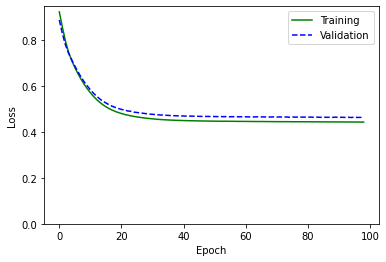

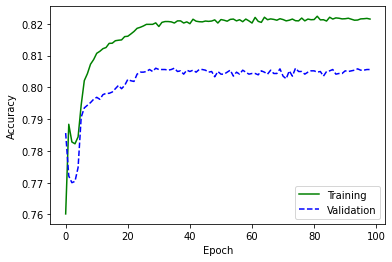

In [42]:
plt.figure()
plt.plot(l2_history.epoch,  l2_history.history['loss'], color="green", label='Train')
plt.plot(l2_history.epoch, l2_history.history['val_loss'],color="blue", linestyle="--", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, plt.ylim()[1]])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.plot(l2_history.epoch,  l2_history.history['accuracy'], color="green", label='Train')
plt.plot(l2_history.epoch, l2_history.history['val_accuracy'],color="blue", linestyle="--", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [43]:
Y_pred=l2_model.predict(X_val)
Y_pred=Y_pred>0.5

cm=confusion_matrix(Y_val,Y_pred)
prf=precision_recall_fscore_support(Y_val,Y_pred)

print(f"confusion matrix\n {cm}")
print(f"precision\n {prf[0]}")
print(f"recall\n {prf[1]}")
print(f"f-score\n {prf[2]}")

confusion matrix
 [[3487  200]
 [ 735  378]]
precision
 [0.82591189 0.65397924]
recall
 [0.94575536 0.33962264]
f-score
 [0.88178025 0.44707274]


In [44]:
cr=classification_report(Y_val, Y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.83      0.95      0.88      3687
           1       0.65      0.34      0.45      1113

    accuracy                           0.81      4800
   macro avg       0.74      0.64      0.66      4800
weighted avg       0.79      0.81      0.78      4800



Applying L2 regularization (with L1 it works very badly) and removing the weights initially applied to the classes the result is a model that suffers a lot for the least frequent class and therefore is not reliable for forecasting. The situation could improve by keeping the weights. 